In [51]:
import os
from os import listdir
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
from keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab import drive
import tensorflow as tf
import cv2
import mimetypes
import argparse
import imutils
import pickle

drive.mount('/content/gdrive')

#/content/drive/MyDrive/ML_eng/Colab Notebooks/fruits_360_img

train = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruits_360_img/Training/'
test = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruits_360_img/Test/'
multi = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruits_360_img/test_multiple_fruits/'

#/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/clementine/clementine 100.jpg
#/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/annotations/red_apple_annotations.csv
#/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/clementine/clementine (49).jpg

Mounted at /content/gdrive


In [52]:
annotations = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/annotations/'
imgs = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/'

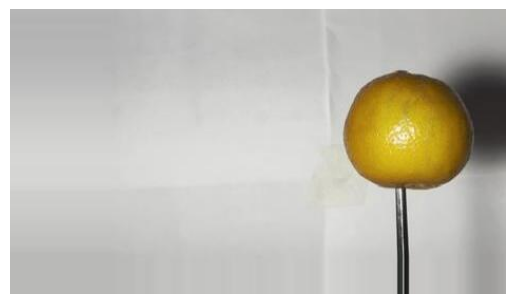

(270, 470, 3)


In [53]:
img = load_img(imgs + 'clementine/clementine (49).jpg')
plt.imshow(img)
plt.axis("off")
plt.show()
#Printing the shape of the image array
x = img_to_array(img)
print(x.shape)

In [54]:
red_apple_anotation = pd.read_csv(annotations + 'red_apple_annotations.csv')
clementine_anotation = pd.read_csv(annotations + 'clementine_annotations.csv')
green_apple_anotation = pd.read_csv(annotations + 'green_apple_annotations.csv')
lime_anotation = pd.read_csv(annotations + 'lime_annotations.csv')

red_apple_anotation.head()

#so rn they are all in a dataframe w/ file name, box size for size prediction, x and y locs and class

,image_index,box_width,box_height,x1,y1,x2,y2,class
0,0,159,158,186,96,345,254,red_apple
1,1,175,132,122,148,297,280,red_apple
2,2,175,159,85,113,260,272,red_apple
3,3,175,155,263,126,438,281,red_apple
4,4,174,161,66,99,240,260,red_apple


In [55]:
frames = [red_apple_anotation, clementine_anotation, green_apple_anotation, lime_anotation]
df = pd.concat(frames)

display(df)
#930 rows by 8 columns perf

,image_index,box_width,box_height,x1,y1,x2,y2,class
0,0,159,158,186,96,345,254,red_apple
1,1,175,132,122,148,297,280,red_apple
2,2,175,159,85,113,260,272,red_apple
3,3,175,155,263,126,438,281,red_apple
4,4,174,161,66,99,240,260,red_apple
...,...,...,...,...,...,...,...,...
414,414,128,128,225,69,353,197,lime
415,415,128,128,228,69,356,197,lime
416,416,129,128,225,70,354,198,lime
417,417,130,129,225,69,355,198,lime


In [56]:
image_data_list = []

red_apple_dir = imgs + 'red_apple/'
clementine_dir = imgs + 'clementine/'
green_apple_dir = imgs + 'green_apple/'
lime_dir = imgs + 'lime/'

fruits_dir = [red_apple_dir, clementine_dir, green_apple_dir, lime_dir]

for fruit in fruits_dir:
  for image in os.listdir(fruit):
    img = load_img(fruit + image, target_size=(270, 470))
    x = img_to_array(img)
    image_data_list.append(x)

image_data_array = np.array(image_data_list)
image_data_array = image_data_array / 255.0
print(image_data_array.shape)

#now image data is in an array

(1676, 135, 235, 3)


In [57]:
ipp = 0.0145

fruit_width = df['box_width'].to_numpy()
fruit_height = df['box_height'].to_numpy()

fruit_width = fruit_width * ipp
fruit_height = fruit_height * ipp

fruit_width = np.transpose([fruit_width, fruit_height])

print(fruit_width.shape)

#print(fruit_dim)

#okay so now the fruit dimensions are in an array

(1676, 2)


In [58]:
#need to scale both the image data and the bound box data from 0-1

x1 = df['x1'].to_numpy()
y1 = df['y1'].to_numpy()
x2 = df['x2'].to_numpy()
y2 = df['y2'].to_numpy()

x1 = x1 / 470
y1 = y1 / 270
x2 = x2 / 470
y2 = y2 / 270

print(x1[0])
print(y1[0])
print(x2[0])
print(y2[0])

bound_box = np.transpose(np.array([x1, y1, x2, y2]))

print(bound_box.shape)

print(bound_box[0])

#cool now the shapes are both normalized and in an array


0.19787234042553192
0.17777777777777778
0.3670212765957447
0.4703703703703704
(1676, 4)
[0.19787234 0.17777778 0.36702128 0.47037037]


In [59]:
#now need class labels

labels = df['class'].to_numpy()
print(labels.shape)

labels[labels == 'red_apple',] = 0
labels[labels == 'clementine',] = 1
labels[labels == 'green_apple',] = 2
labels[labels == 'lime',] = 3

labels = to_categorical(labels)
print(labels.shape)
print(labels)

#okay so now all images are in numpy arrays, all box locs are in numpy arrays, and labels are catigorical

(1676,)
(1676, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [60]:
#splitting data

img_train, img_test, labels_train, labels_test, bb_train, bb_test, fruit_width_train, fruit_width_test = train_test_split(image_data_array, labels, bound_box, fruit_width, test_size=0.2, random_state=14, shuffle = True)

print(img_train.shape)
print(img_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(bb_train.shape)
print(bb_test.shape)
print(fruit_width_train.shape)
print(fruit_width_test.shape)

#data prep should be done?

(1340, 135, 235, 3)
(336, 135, 235, 3)
(1340, 4)
(336, 4)
(1340, 4)
(336, 4)
(1340, 2)
(336, 2)


In [61]:
train_targets = {"class_label": labels_train, "bounding_box": bb_train, "fruit_width": fruit_width_train}

test_targets = {"class_label": labels_test, "bounding_box": bb_test, "fruit_width": fruit_width_test}

In [62]:
inputs = Input(shape = (270, 470, 3))
model = Sequential()
model = Conv2D(filters=512, kernel_size=(7, 7), padding='valid',
               activation='relu', input_shape=(270, 470, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='valid',
               activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5),padding='valid',
               activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5),padding='valid',
               activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='valid',
               activation='relu')(model)
model = Flatten()(model)

labelhead = Dense(64, activation="relu")(model)
labelhead = Dropout(0.3)(labelhead)
labelhead = Dense(32, activation="relu")(labelhead)
labelhead = Dropout(0.3)(labelhead)
labelhead = Dense(4, activation = 'softmax', name = 'class_label')(labelhead)

boundryhead = Dense(256, activation="relu")(model)
boundryhead = Dropout(0.3)(boundryhead)
boundryhead = Dense(64, activation="relu")(boundryhead)
boundryhead = Dense(16, activation="relu")(boundryhead)
boundryhead = Dense(4, activation = 'sigmoid', name =
                    'bounding_box')(boundryhead)

fruit_dim = Dense(32, activation="ReLU")(model)
fruit_dim = Dense(16, activation="ReLU")(fruit_dim)
fruit_dim = Dense(2, activation = 'linear', name = 'fruit_width')(fruit_dim)

model = Model(inputs=inputs, outputs=[labelhead, boundryhead, fruit_dim])

opt = Adam(learning_rate = 0.00001)
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error", "fruit_width": "mean_squared_error"}

lossWeights = {"class_label": 1.0, "bounding_box": 1.0, "fruit_width": 1.0}

model.compile(loss = losses, optimizer = opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 135, 235, 3)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 129, 229, 1024)       151552    ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 114, 1024)        0         ['conv2d_20[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 60, 110, 512)         1310771   ['max_pooling2d_16[0][0]

In [43]:
history = model.fit(img_train, train_targets, epochs=20, batch_size=32, validation_data=(img_test, test_targets))

Epoch 1/20
42/42 [==============================] - 147s 2s/step - loss: 3.5920 - class_label_loss: 1.7771 - bounding_box_loss: 0.0644 - fruit_width_loss: 1.7505 - class_label_accuracy: 0.2597 - bounding_box_accuracy: 0.3112 - fruit_width_accuracy: 0.4687 - val_loss: 2.2355 - val_class_label_loss: 1.8392 - val_bounding_box_loss: 0.0388 - val_fruit_width_loss: 0.3575 - val_class_label_accuracy: 0.2024 - val_bounding_box_accuracy: 0.7292 - val_fruit_width_accuracy: 0.5893
Epoch 2/20
42/42 [==============================] - 33s 788ms/step - loss: 2.1226 - class_label_loss: 1.7750 - bounding_box_loss: 0.0341 - fruit_width_loss: 0.3135 - class_label_accuracy: 0.2470 - bounding_box_accuracy: 0.6455 - fruit_width_accuracy: 0.4813 - val_loss: 1.8330 - val_class_label_loss: 1.5768 - val_bounding_box_loss: 0.0130 - val_fruit_width_loss: 0.2432 - val_class_label_accuracy: 0.2024 - val_bounding_box_accuracy: 0.8214 - val_fruit_width_accuracy: 0.5268
Epoch 3/20
42/42 [==============================

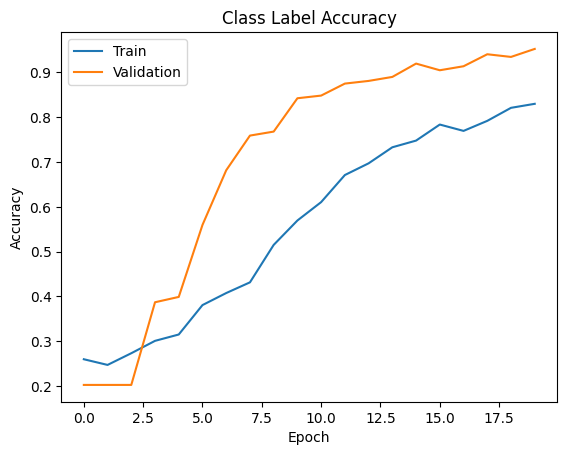

In [44]:
plt.plot(history.history['class_label_accuracy'])
plt.plot(history.history['val_class_label_accuracy'])
plt.title('Class Label Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

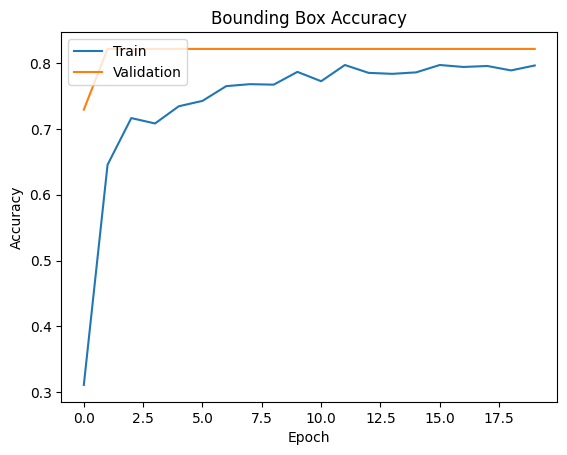

In [45]:
plt.plot(history.history['bounding_box_accuracy'])
plt.plot(history.history['val_bounding_box_accuracy'])
plt.title('Bounding Box Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

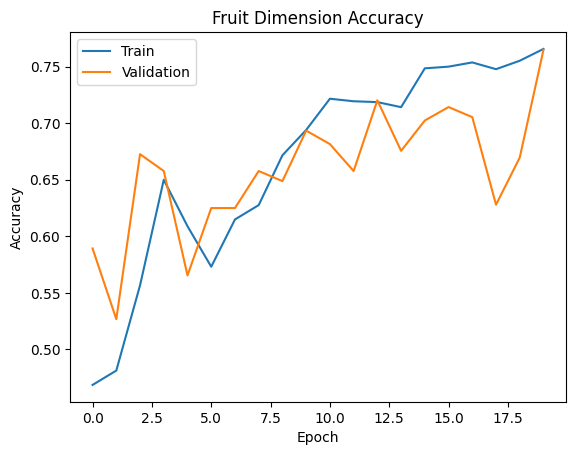

In [46]:
plt.plot(history.history['fruit_width_accuracy'])
plt.plot(history.history['val_fruit_width_accuracy'])
plt.title('Fruit Dimension Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
lime


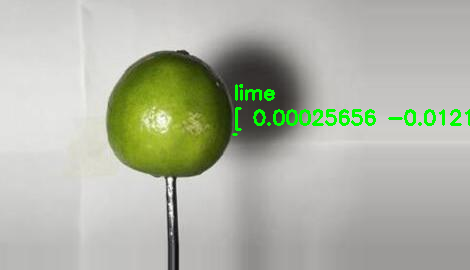

-1

In [64]:
from google.colab.patches import cv2_imshow

imagePath = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/lime/lime (100).jpg'

image = load_img(imagePath, target_size=(270, 470))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
(labelPreds, boxPreds, fruitDim) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]

	# determine the class label with the largest predicted
	# probability


print(label)

image = cv2.imread(imagePath)

h = 270
w = 470
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# draw the predicted bounding box and class label on the image

label = "lime"
dim = str(fruitDim[0])

cv2.putText(image, label, (startX, startY - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.putText(image, dim, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 23ms/step
[[0.24822384 0.25268528 0.24715663 0.25193426]]
[[-0.00053774 -0.00956709]]
240 134 240 134


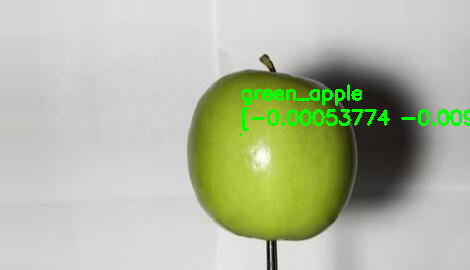

-1

In [65]:
imagePath = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/clementine/clementine 131.jpg'

image = load_img(imagePath, target_size=(270, 480))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
(labelPreds, boxPreds, fruitDim) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
#i = np.argmax(labelPreds, axis=1)
#label = lb.classes_[i][0]

print(labelPreds)

print(fruitDim)

image = cv2.imread(imagePath)

h = 270
w = 480
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

print(startX, startY, endX, endY)

# draw the predicted bounding box and class label on the image

label = "clementine"
dim = '1.898 x 1.602'

cv2.putText(image, label, (startX, startY - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.putText(image, dim, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

1/1 [==============================] - 0s 21ms/step
[[2.6449434e-06 9.9959224e-01 2.5704145e-04 1.4808137e-04]]
[[1.8260608 1.8238474]]
215 103 321 206


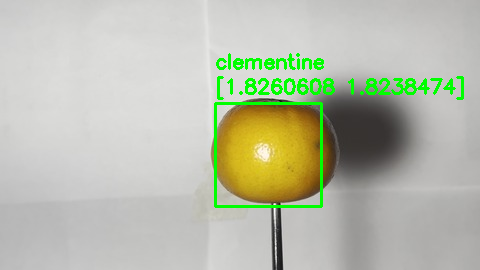

-1

In [17]:
imagePath = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/clementine/clementine (243).jpg'

image = load_img(imagePath, target_size=(270, 470))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
(labelPreds, boxPreds, fruitDim) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
#i = np.argmax(labelPreds, axis=1)
#label = lb.classes_[i][0]

print(labelPreds)

print(fruitDim)

image = cv2.imread(imagePath)

h = 270
w = 480
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

print(startX, startY, endX, endY)

# draw the predicted bounding box and class label on the image

label = 'clementine'
dim = str(fruitDim[0])

cv2.putText(image, label, (startX, startY - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.putText(image, dim, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

1/1 [==============================] - 0s 21ms/step
[[9.97352481e-01 1.16445284e-04 5.73419356e-07 2.53052381e-03]]
[[2.677924 2.41815 ]]
179 105 325 243
0      186
1      122
2       85
3      263
4       66
      ... 
414    225
415    228
416    225
417    225
418    225
Name: x1, Length: 1676, dtype: int64


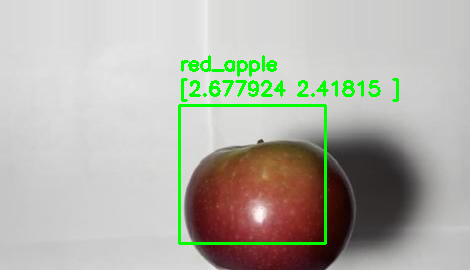

-1

In [18]:
imagePath = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/red_apple/red_apple (122).jpg'

image = load_img(imagePath, target_size=(270, 470))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
(labelPreds, boxPreds, fruitDim) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
#i = np.argmax(labelPreds, axis=1)
#label = lb.classes_[i][0]

print(labelPreds)

print(fruitDim)

image = cv2.imread(imagePath)

h = 270
w = 480
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

print(startX, startY, endX, endY)

original_bound = df['x1']
print(original_bound)

# draw the predicted bounding box and class label on the image

label = "red_apple"
dim = str(fruitDim[0])

cv2.putText(image, label, (startX, startY - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.putText(image, dim, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

1/1 [==============================] - 0s 24ms/step
[[0.00406476 0.00793758 0.08036015 0.9076375 ]]
[[1.5954995 1.7279534]]
233 88 320 198
0      186
1      122
2       85
3      263
4       66
      ... 
414    225
415    228
416    225
417    225
418    225
Name: x1, Length: 1676, dtype: int64


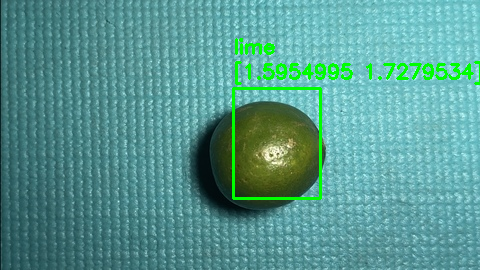

-1

In [26]:
imagePath = '/content/gdrive/MyDrive/ML_eng/Colab Notebooks/fruit_homemade/images/validation_fruit/lime_10.jpg'

image = load_img(imagePath, target_size=(270, 470))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
	# predict the bounding box of the object along with the class
	# label
(labelPreds, boxPreds, fruitDim) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
#i = np.argmax(labelPreds, axis=1)
#label = lb.classes_[i][0]

print(labelPreds)

print(fruitDim)

image = cv2.imread(imagePath)

h = 270
w = 480
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

print(startX, startY, endX, endY)

original_bound = df['x1']
print(original_bound)

# draw the predicted bounding box and class label on the image

label = "lime"
dim = str(fruitDim[0])

cv2.putText(image, label, (startX, startY - 35), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.putText(image, dim, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)